In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [3]:
# context length, how many chars do we take to predict the next char:
block_size = 7

# build the dataset:
def build_dataset(words):
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.': # there is no need for '.' + w + '.'
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

In [4]:
n_embed = 10 # each character will be represented by 10 dimensions
n_hidden = 200
EPS = 1e-5

C = torch.randn((vocab_size, n_embed)) 

W1 = torch.randn((n_embed * block_size, n_hidden)) * (5 / 3) / ((n_embed * block_size) ** 0.5)
#b1 = torch.randn(n_hidden) * 0.01

W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0.01

# for batch-norm:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

# number of parameters in total:
sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [5]:
for i in range(200000):
    # contruct minibatch -> get 32 random contexts from the dataset:
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass:
    emb = C[Xtr[ix]] # -> [batch_size, block_size, n_embed]
    embcat = emb.view(emb.shape[0], -1) # -> [batch_size, block_size * n_embed]
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True) + 1e-5) + bnbias
    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmean_i) / (bnstd_i + 1e-5)) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass:
    for p in parameters:
        p.grad = None

    loss.backward()

    # update:
    lr = 0.1 if i < 100000 else 0.1

    for p in parameters:
        p.data -= lr * p.grad

    

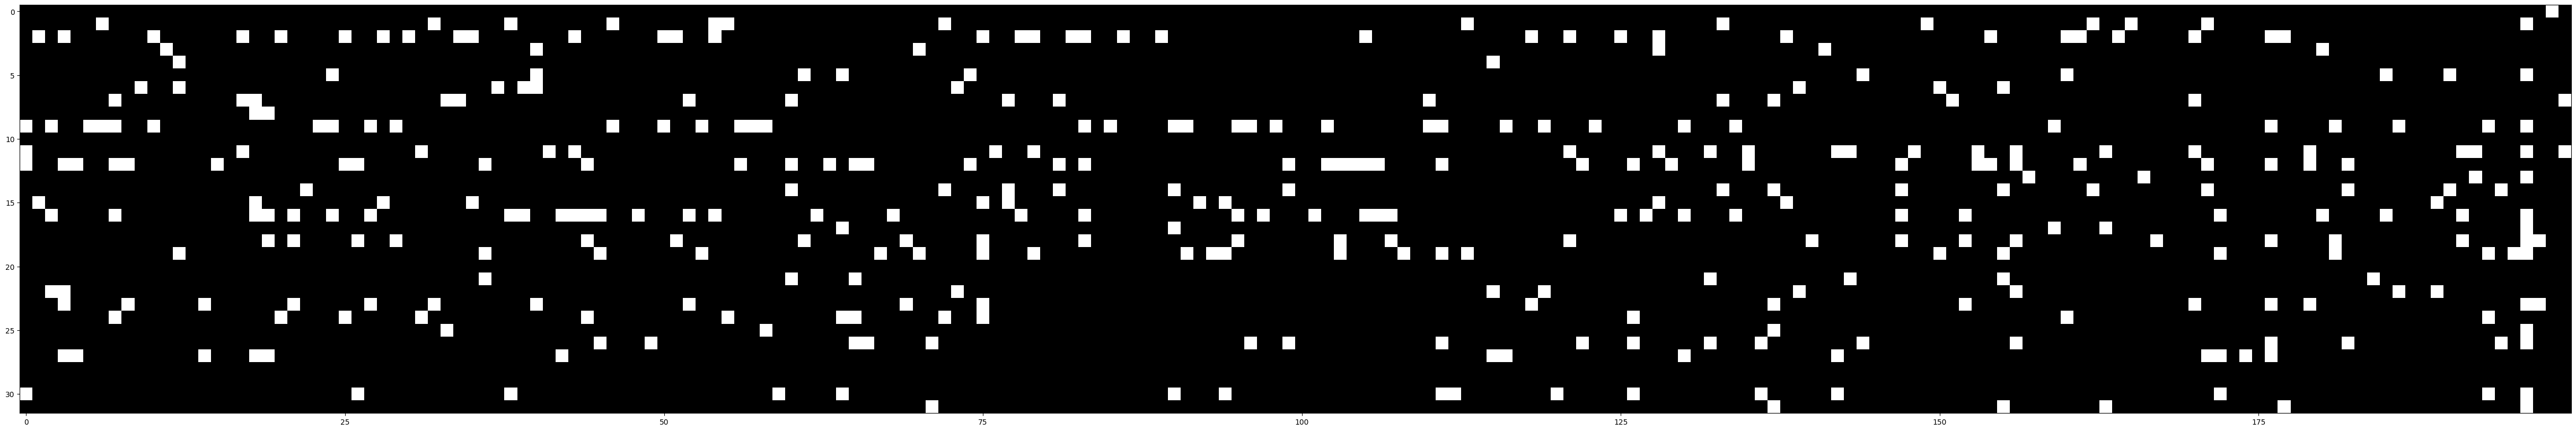

In [6]:
plt.figure(figsize=(290, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# if the plot is all white -> tanh function very active -> its destroying the backward gradient
# (setting it to zero) -> we get a lot of dead neurons

In [7]:
# disable gradient tracking
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte}
    } [split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True) + 1e-5) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running + 1e-5)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0043883323669434
val 2.1085638999938965


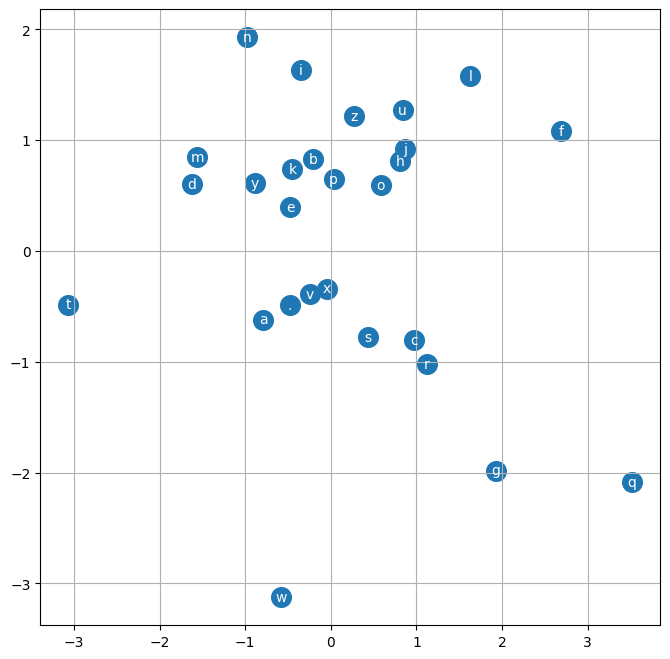

In [8]:
plt.figure(figsize= (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

In [9]:
# sample from the model:

with torch.no_grad():
    for _ in range(20):

        out = []
        context = [0] * block_size
        
        while True:
            emb = C[torch.tensor([context])]
            embcat = emb.view(emb.shape[0], -1)
            hpreact = embcat @ W1 #+ b1
            # hpreact = bngain * (hpreact - hpreact.mean(-1, keepdim=True) / hpreact.std(-1, keepdim=True) + 1e-5) + bnbias
            hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running + 1e-5)) + bnbias
            h = torch.tanh(hpreact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            if ix == 0: break
            out.append(ix)

        print(''.join(itos[i] for i in out)) 



wisvin
ziyon
ezien
temoni
arreers
vaniyl
arishiker
jona
azias
lynn
nahmari
cean
nikaila
ecarlette
marquel
tayda
shenza
nuo
ahra
jazyon
